In [3]:
import pandas as pd

df_predictions = pd.read_csv("11-predicitions.csv", lineterminator="\n")
df_tweets = pd.read_csv(
    "data/Twitter/epinetz_download_100per.tsv", sep="\t", lineterminator="\n"
)
df_collection = pd.read_csv("data/Twitter/collection_v10.csv")

df_predictions = pd.merge(df_tweets, df_predictions, on="Unnamed: 0")

#add collection data
collection_columns = ["official_name","region","institution","office","user_id","twitter_name","twitter_handle"]
df_predictions = pd.merge(df_predictions, df_collection[collection_columns], left_on="_source__author_id", right_on="user_id")

# columns
print(df_predictions.columns)

Index(['Unnamed: 0', '_index', '_type', '_id', '_score', '_ignored',
       '_source__like_count', '_source__attachments',
       '_source__possibly_sensitive', '_source__created_at',
       '_source__nlp_pipeline_applied', '_source__reply_count',
       '_source__withheld', '_source__retweet_count',
       '_source__context_annotations', '_source__user_role',
       '_source__entities__urls', '_source__entities__hashtags',
       '_source__entities__mentions', '_source__author_party',
       '_source__conversation_id', '_source__in_reply_to_user_id',
       '_source__text', '_source__author_id', '_source__lang',
       '_source__quote_count', '_source__replicated',
       '_source__attachments__media_keys', '_source__entities__annotations',
       '_source__entities', '_source__real_name',
       '_source__profile_description', '_source__user_type',
       '_source__username', 'text', 'prediction_class1', 'official_name',
       'region', 'institution', 'office', 'user_id', 'twitter_n

/tmp/ipykernel_168413/2332956917.py:4: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tweets = pd.read_csv(


In [4]:
'''Create Small DF'''
wanted_columns = ["_id", "_source__like_count", "_source__author_party", "user_id", "official_name", "region", "prediction_class1", "_source__lang"]
df_predictions_small = df_predictions[wanted_columns]

print(df_predictions_small.head)


<bound method NDFrame.head of                        _id  _source__like_count _source__author_party  \
0       985555092236656640                    0             DIE LINKE   
1      1132217940110131200                    9             DIE LINKE   
2      1196046889621377026                    0             DIE LINKE   
3      1196026789719629826                   12             DIE LINKE   
4      1005514786774441985                    0             DIE LINKE   
...                    ...                  ...                   ...   
55542  1094992232300593154                   36                   FDP   
55543  1053232477840556033                    0                   FDP   
55544  1053232477840556033                    0                   FDP   
55545  1153765011434721280                    0                   FDP   
55546  1153765011434721280                    0                   FDP   

          user_id            official_name   region  prediction_class1  \
0      1683845126  

In [5]:
# only german tweets (thats what the model is trained for)
df_predictions_small_de = df_predictions_small[df_predictions_small["_source__lang"] == "de"]
print(df_predictions_small_de.value_counts("_source__lang"))

df_small = df_predictions_small_de


_source__lang
de    51937
Name: count, dtype: int64


DESCRIPTION HATE-COLUMN:
count    51937.000000
mean         0.304485
std          0.050911
min          0.269363
25%          0.276800
50%          0.285802
75%          0.307549
max          0.701492
Name: prediction_class1, dtype: float64


/tmp/ipykernel_168413/2640641285.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small["prediction_class1_norm"] = df_small["prediction_class1"].map(normalizing)


<Axes: ylabel='Density'>

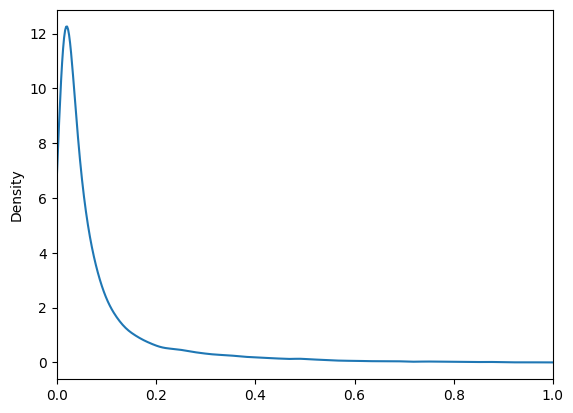

In [28]:
print("DESCRIPTION HATE-COLUMN:")
print(df_small["prediction_class1"].describe())

global max
global min
max = 0.701492
min = 0.269363

def normalizing(x):
    range = max - min
    correctedStartValue = x - min
    percentage = (correctedStartValue) / range 
    
    return round(percentage, 2)

df_small["prediction_class1_norm"] = df_small["prediction_class1"].map(normalizing)

df_small['prediction_class1_norm'].plot(kind='kde', xlim=[0,1])

#df_small

NUM AUTHORS
518
           _source__author_party  count  prediction_class1_norm
2                      DIE LINKE   5937                    0.05
3                     DIE PARTEI     92                    0.05
5          Bündnis 90/Die Grünen   7074                    0.04
6                            SPD  11669                    0.03
4                            FDP   8245                    0.04
7                            CDU   8812                    0.03
8                            CSU   2848                    0.03
0  Liberal-Konservative Reformer     89                    0.06
1                            AfD   7171                    0.05


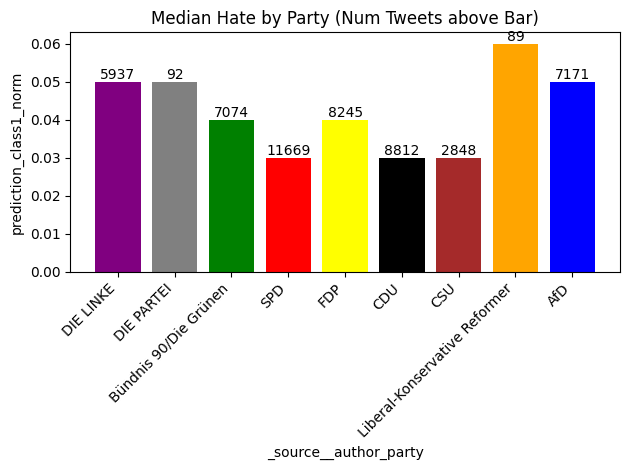

In [18]:
import matplotlib.pyplot as plt

print("NUM AUTHORS")
print(df_small["official_name"].nunique())

tweets_per_party = df_small["_source__author_party"].value_counts()
hate_mean_party = df_small.groupby('_source__author_party')['prediction_class1_norm'].median()

df = pd.concat([tweets_per_party, hate_mean_party], axis=1).sort_values('prediction_class1_norm', ascending=False).reset_index()

# Party colors
party_colors = {
    'Liberal-Konservative Reformer': 'orange',
    'AfD': 'blue',
    'DIE LINKE': 'purple',
    'Bündnis 90/Die Grünen': 'green',
    'DIE PARTEI': 'grey',
    'FDP': 'yellow',
    'SPD': 'red',
    'CDU': 'black',
    'CSU': 'brown'
}

# Define the manual order of parties
manual_order = [
    'DIE LINKE',
    'DIE PARTEI',
    'Bündnis 90/Die Grünen',

    'SPD',
    'FDP',
    'CDU',
    'CSU',
    'Liberal-Konservative Reformer',
    'AfD'
]

# Reorder the DataFrame based on manual_order
df['_source__author_party'] = pd.Categorical(df['_source__author_party'], categories=manual_order, ordered=True)
df = df.sort_values('_source__author_party')
print(df)


# Set the figure and axes
fig, ax = plt.subplots()

# Create the bar plot with colored bars
bars = ax.bar(df['_source__author_party'], df['prediction_class1_norm'], color=[party_colors[party] for party in df['_source__author_party']])

# Add counts as text labels above the bars
for bar, count in zip(bars, df['count']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, count,
            ha='center', va='bottom')

# Add labels and title
ax.set_xlabel('_source__author_party')
ax.set_ylabel('prediction_class1_norm')
ax.set_title('Median Hate by Party (Num Tweets above Bar)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

In [10]:
df_small.pivot_table('prediction_class1_norm', ['_source__author_party', 'region'], aggfunc='mean').sort_values('prediction_class1_norm', ascending=False).reset_index()

,_source__author_party,region,prediction_class1_norm
0,Liberal-Konservative Reformer,Federal,0.138989
1,AfD,Berlin,0.132143
2,DIE LINKE,Berlin,0.120928
3,AfD,Bremen,0.120909
4,AfD,Hamburg,0.120625
5,Bündnis 90/Die Grünen,North Rhine-Westphalia,0.116421
6,AfD,Federal,0.110072
7,AfD,Saxony-Anhalt,0.099550
8,DIE LINKE,Federal,0.096405
9,SPD,Lower Saxony,0.094286


In [32]:
print("MEAN HATE PER PERSON")
mean_hate_person = df_small.groupby('user_id')['prediction_class1'].mean().sort_values(ascending=False)
mean_hate_person_party = pd.merge(mean_hate_person, df_small[["_source__author_party", "official_name", "user_id"]], on="user_id")
mean_hate_person_party[["official_name", "_source__author_party", "prediction_class1"]].drop_duplicates(keep="first").reset_index(drop=True)

MEAN HATE PER PERSON


,official_name,_source__author_party,prediction_class1
0,Markus Paschke,SPD,0.389783
1,Martin Reichardt,AfD,0.354130
2,Frank Pasemann,AfD,0.344609
3,Rainer Kraft,AfD,0.341348
4,Christoph de Vries,CDU,0.340018
...,...,...,...
516,Gero Storjohann,CDU,0.279241
517,Hansjörg Durz,CSU,0.277840
518,Ingo Gädechens,CDU,0.276077
519,Dietrich Monstadt,CDU,0.275309


In [ ]:
df_small.to_csv("21-all-combined.tsv", sep="\t", lineterminator="\n")